In [153]:
import csv
with open("exchange_rate.csv", 'w',newline="") as file:
    csv_write = csv.writer(file, delimiter=',') #header
    csv_write.writerow(["Currency","Rate"]) #data /record
    csv_write.writerow(["EUR","0.93"])
    csv_write.writerow(["GBP","0.8"])
    csv_write.writerow(["INR","82.95"])

In [154]:
import logging
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import sqlite3
import matplotlib.pyplot as plt

In [155]:
# Task 1: Logging function
def setup_logging():
    logging.basicConfig(filename='project.log', 
                        level=logging.INFO, 
                        format='%(asctime)s - %(levelname)s - %(message)s')

def log_message(message):
    logging.info(message)


In [156]:
def extract_data(url):
    log_message(f"Attempting to fetch data from {url}...")
    response = requests.get(url)
    
    if response.status_code == 200:
        log_message('Successfully fetched the webpage.')
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        log_message('Failed to fetch the webpage.')
        return None

In [157]:
def transform_data(soup):
    tables = soup.find_all('table', class_='wikitable')
    if tables:
        table_str = str(tables[0])
        table_io = StringIO(table_str) 
        df_list = pd.read_html(table_io)
        df = df_list[0]  # Assuming the first table is the one we need
        log_message("Data transformed into DataFrame")
        return df
    else:
        log_message("No tables found")
        return None

In [158]:
def apply_exchange_rates(df, exchange_rate_file):
    exchange_rates = pd.read_csv(exchange_rate_file)
    rates = dict(zip(exchange_rates['Currency'], exchange_rates['Rate']))
    
    # Apply exchange rates to convert market cap to different currencies
    df['Market cap (INR Billion)'] = df['Market cap (US$ billion)'] * rates.get('INR', 1)
    df['Market cap (EUR Billion)'] = df['Market cap (US$ billion)'] * rates.get('EUR', 1)
    df['Market cap (GBP Billion)'] = df['Market cap (US$ billion)'] * rates.get('GBP', 1)
    
    log_message("Data transformed with exchange rates")
    return df

In [159]:
def load_to_csv(df, filename='Largest_banks.csv'):
    df.to_csv(filename, index=False)
    log_message(f'Data loaded to CSV file: {filename}')


In [160]:
def load_to_database(df, db_name, table_name):
    conn = sqlite3.connect(db_name)
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()
    log_message(f"Data loaded into SQLite database: {table_name}")


In [161]:
def query_database(db_name, query):
    conn = sqlite3.connect(db_name)
    result = pd.read_sql_query(query, conn)
    conn.close()
    log_message(f"Query executed: {query}")
    return result

In [162]:
def visualize_dataUS(df):
    df.plot(kind='bar', x='Bank name', y='Market cap (US$ billion)')
    plt.title('Largest Banks by Market Cap (US$ billion)')
    plt.xlabel('Bank Name')
    plt.ylabel('Market Cap (US$ Billion)')
    plt.show()
    log_message("Data visualization created for Largest Banks by Market Cap (US$ billion)') ")
def visualize_query1(result):
    result.plot(kind='bar', x='Bank name', y='Bank_Count')
    plt.title('Count of Banks with Market Cap Greater Than $100 Billion')
    plt.xlabel('Bank Name')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    log_message("Data visualization created for Count of Banks with Market Cap Greater Than $100 Billion ")
def visualize_query2(result):
    result.plot(kind='bar', x='Bank name', y='Market cap (GBP Billion)')
    plt.title('Banks with Market Cap in GBP Billion > 200')
    plt.xlabel('Market Cap (GBP Billion)')
    plt.ylabel('Bank Name')
    plt.tight_layout()
    plt.show()    
    log_message("Data visualization created for Banks with Market Cap in GBP Billion > 200 ")

def visualize_query3(result):
    result.plot(kind='bar', x='Bank name', y='Market cap (INR Billion)')
    plt.title('Top Banks by Market Cap in INR Billion')
    plt.xlabel('Bank Name')
    plt.ylabel('Market Cap (INR Billion)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    log_message("Data visualization created for Top Banks by Market Cap in INR Billion ")

def visualize_query4(result):
    #plt.figure(figsize=(10, 6))
    plt.pie(result['Market cap (US$ billion)'], labels=result['Bank name'], autopct='%1.1f%%', startangle=140)
    plt.title('Bank with the Maximum Market Cap in US$ Billion')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    log_message("Data visualization created for Bank with the Maximum Market Cap in US$ Billion ")


In [163]:
def verify_log():
    with open('project.log', 'r') as log_file:
        print(log_file.read())

In [164]:
def main():
    setup_logging()
    log_message("Logging setup complete.")
    
    # URL for scraping
    url = "https://web.archive.org/web/20230908091635/https:/en.wikipedia.org/wiki/List_of_largest_banks"
    soup = extract_data(url)
    
    if soup:
        log_message("Data extraction from Wikipedia successful.")
        df = transform_data(soup)
        
        if df is not None:
            log_message("Data transformation successful.")
            print(df.columns)
            #print(df)
            
            # Apply exchange rates
            exchange_rate_file = 'exchange_rate.csv'
            df = apply_exchange_rates(df, exchange_rate_file)
            #print(df)
            
            # Load to CSV
            csv_filename = 'Largest_banks.csv'
            load_to_csv(df, csv_filename)
            
            # Load to SQLite database
            db_name = 'banks.db'
            table_name = 'Largest_banks'
            load_to_database(df, db_name, table_name)
            
            # Query database
            query1 = "SELECT `Bank name`,COUNT(*) as Bank_Count FROM Largest_banks WHERE `Market cap (US$ billion)` > 100"
            query2 = "SELECT `Bank name`, `Market cap (GBP billion)` FROM Largest_banks WHERE `Market cap (GBP billion)` > 200"
            query3 = "SELECT `Bank name`, `Market cap (INR Billion)` FROM Largest_banks ORDER BY `Market cap (INR Billion)` DESC"
            query4 = "SELECT `Bank name`, `Market cap (US$ billion)` FROM Largest_banks WHERE `Market cap (US$ billion)` = (SELECT MAX(`Market cap (US$ billion)`) FROM banks)"            
            result1 = query_database(db_name, query1)
            print("Query No: 01")
            print(result1)
            
            result2 = query_database(db_name, query2)
            print("\nQuery No: 02")
            print(result2)
            
            result3 = query_database(db_name, query3)
            print("\nQuery No: 03")
            print(result3)

            result4 = query_database(db_name, query4)
            print("\nQuery No: 04")
            print(result4)

            # Visualize data
            visualize_dataUS(df)
            visualize_query1(result1)
            visualize_query2(result2)
            visualize_query3(result3)
            visualize_query4(result4)
        else:
            log_message("Data transformation failed.")
    else:
        log_message("Data extraction from Wikipedia failed.")
    
    # Verify log entries
    verify_log()

Index(['Rank', 'Bank name', 'Market cap (US$ billion)'], dtype='object')
Query No: 01
        Bank name  Bank_Count
0  JPMorgan Chase          10

Query No: 02
        Bank name  Market cap (GBP Billion)
0  JPMorgan Chase                   346.336

Query No: 03
                                 Bank name  Market cap (INR Billion)
0                           JPMorgan Chase                35910.7140
1                          Bank of America                19204.5840
2  Industrial and Commercial Bank of China                16138.7520
3               Agricultural Bank of China                13328.4060
4                                HDFC Bank                13098.6345
5                              Wells Fargo                12929.4165
6                        HSBC Holdings PLC                12351.2550
7                           Morgan Stanley                11681.8485
8                  China Construction Bank                11598.0690
9                            Bank of China      

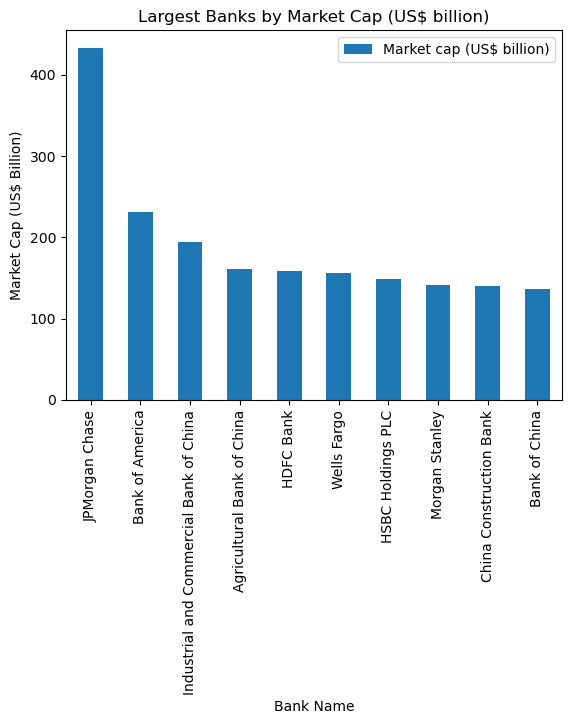

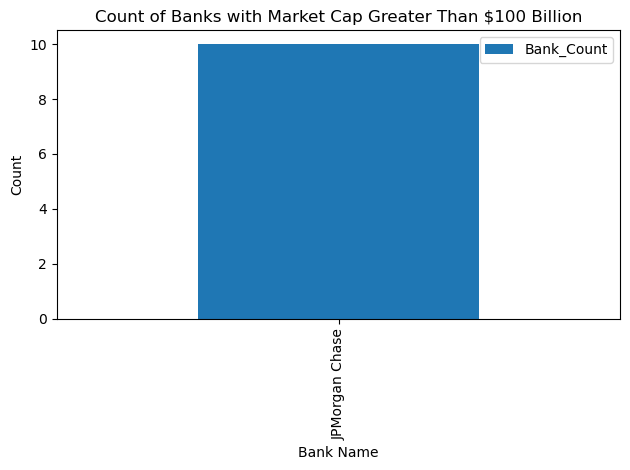

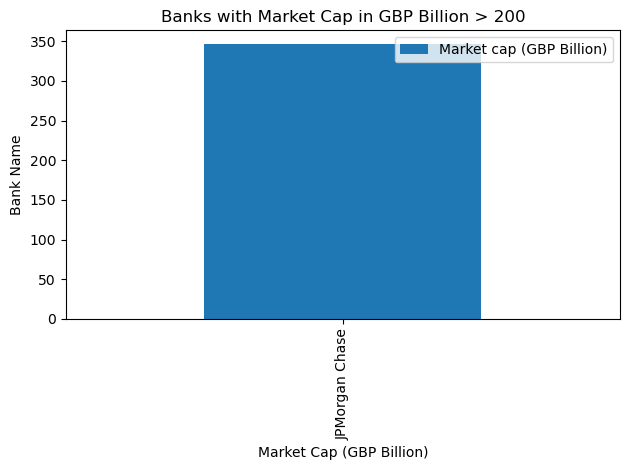

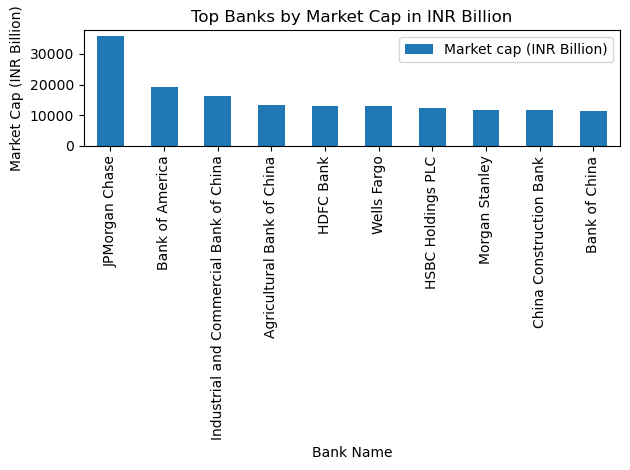

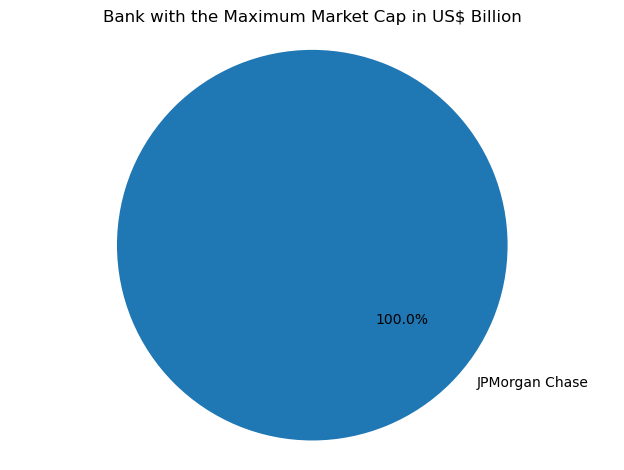

2024-07-11 15:14:49,907 - INFO - Logging setup complete.
2024-07-11 15:14:49,908 - INFO - Attempting to fetch data from https://web.archive.org/web/20230908091635/https:/en.wikipedia.org/wiki/List_of_largest_banks...
2024-07-11 15:14:52,649 - INFO - Successfully fetched the webpage.
2024-07-11 15:14:52,769 - INFO - Data extraction from Wikipedia successful.
2024-07-11 15:14:52,804 - INFO - Data transformed into DataFrame
2024-07-11 15:14:52,804 - INFO - Data transformation successful.
2024-07-11 15:14:52,813 - INFO - Data transformed with exchange rates
2024-07-11 15:14:52,816 - INFO - Data loaded to CSV file: Largest_banks.csv
2024-07-11 15:14:52,857 - INFO - Data loaded into SQLite database: Largest_banks
2024-07-11 15:14:52,862 - INFO - Query executed: SELECT `Bank name`,COUNT(*) as Bank_Count FROM Largest_banks WHERE `Market cap (US$ billion)` > 100
2024-07-11 15:14:52,866 - INFO - Query executed: SELECT `Bank name`, `Market cap (GBP billion)` FROM Largest_banks WHERE `Market cap (

In [165]:
if __name__ == "__main__":
    main()